### Imports and preparation

In [81]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import col, lower, trim, avg, when
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [82]:
# Create a SparkSessoin
spark = SparkSession.builder.appName('ml-road').getOrCreate()

# Read Excel file into Pandas dataframe
df_crashes_pd = pd.read_excel('./bitre_fatal_crashes_aug2023.xlsx',sheet_name='BITRE_Fatal_Crash',skiprows=4)

# Create custom schemas
schema_crashes = StructType([
    StructField("CRASH_ID", StringType(), False), 
    StructField("STATE", StringType(), True),
    StructField("MONTH", StringType(), True),
    StructField("YEAR", IntegerType(), True),
    StructField("DAYWEEK", StringType(), True),
    StructField("TIME", StringType(), True),
    StructField("CRASH_TYPE", StringType(), True),
    StructField("NUMBER_FATALITIES", IntegerType(), True),
    StructField("BUS_INVOLVEMENT", StringType(), True),
    StructField("HEAVY_TRUCK_INVOLVEMENT", StringType(), True),
    StructField("ARTICULATED_TRUCK_INVOLVEMENT", StringType(), True),
    StructField("SPEED_LIMIT", StringType(), True),
    StructField("NATIONAL_REMOTENESS", StringType(), True),
    StructField("SA4_NAME", StringType(), True),
    StructField("NATIONAL_LGA", StringType(), True),
    StructField("NATIONAL_ROAD_TYPE", StringType(), True),
    StructField("CHRISTMAS", StringType(), True),
    StructField("EASTER", StringType(), True),
    StructField("DAYOFWEEK", StringType(), True),
    StructField("TIMEOFDAY", StringType(), True)
])


# Convert Pandas dataframe to Spark dataframe
df_crashes_spark = spark.createDataFrame(df_crashes_pd, schema_crashes)

# Show top 3 rows
df_crashes_spark.show(3)


+--------+-----+-----+----+--------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+------------+------------------+---------+------+---------+---------+
|CRASH_ID|STATE|MONTH|YEAR| DAYWEEK|                TIME|CRASH_TYPE|NUMBER_FATALITIES|BUS_INVOLVEMENT|HEAVY_TRUCK_INVOLVEMENT|ARTICULATED_TRUCK_INVOLVEMENT|SPEED_LIMIT| NATIONAL_REMOTENESS|            SA4_NAME|NATIONAL_LGA|NATIONAL_ROAD_TYPE|CHRISTMAS|EASTER|DAYOFWEEK|TIMEOFDAY|
+--------+-----+-----+----+--------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+------------+------------------+---------+------+---------+---------+
|20232113|  Vic|    8|2023|Saturday|Time: 16 hours, 9...|  Multiple|                1|             -9|                     -9|                           -9|    

Adding a new column to highlight the severity of the crash. Multi = multideath crash. Single = single death crash.

In [83]:
# Add a new column 'DEATH_CATEGORY' based on 'NUMBER_FATALITIES' column
df_crashes_spark = df_crashes_spark.withColumn(
    'DEATH_CATEGORY',
    when(col('NUMBER_FATALITIES') > 1, 'Multi').otherwise('Single')
)

# Show the DataFrame with the new column
df_crashes_spark.show()

+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+----------------+--------------------+---------+------+---------+---------+--------------+
|CRASH_ID|STATE|MONTH|YEAR|  DAYWEEK|                TIME|CRASH_TYPE|NUMBER_FATALITIES|BUS_INVOLVEMENT|HEAVY_TRUCK_INVOLVEMENT|ARTICULATED_TRUCK_INVOLVEMENT|SPEED_LIMIT| NATIONAL_REMOTENESS|            SA4_NAME|    NATIONAL_LGA|  NATIONAL_ROAD_TYPE|CHRISTMAS|EASTER|DAYOFWEEK|TIMEOFDAY|DEATH_CATEGORY|
+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+----------------+--------------------+---------+------+---------+---------+--------------+
|20232113|  Vic|    8|2023| Saturday|Time: 16 hours, 9...|  Multiple|                1|       

In [84]:
df_crashes_spark.printSchema()

root
 |-- CRASH_ID: string (nullable = false)
 |-- STATE: string (nullable = true)
 |-- MONTH: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- DAYWEEK: string (nullable = true)
 |-- TIME: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- NUMBER_FATALITIES: integer (nullable = true)
 |-- BUS_INVOLVEMENT: string (nullable = true)
 |-- HEAVY_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- ARTICULATED_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- SPEED_LIMIT: string (nullable = true)
 |-- NATIONAL_REMOTENESS: string (nullable = true)
 |-- SA4_NAME: string (nullable = true)
 |-- NATIONAL_LGA: string (nullable = true)
 |-- NATIONAL_ROAD_TYPE: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- DAYOFWEEK: string (nullable = true)
 |-- TIMEOFDAY: string (nullable = true)
 |-- DEATH_CATEGORY: string (nullable = false)



### EDA


Exploring the dataset to find trends to explore further

In [85]:
# Get a list of the string column names (categorical variables)
categorical_columns = [col_name for col_name, col_type in df_crashes_spark.dtypes if col_type == 'string']

# Initialize an empty dictionary to store unique options for each column
unique_options = {}

# Loop through the categorical columns and find unique options
for column in categorical_columns:
    distinct_values = df_crashes_spark.select(column).distinct().rdd.flatMap(lambda x: x).collect()
    unique_options[column] = distinct_values

# Print the unique options for each categorical variable
for column, options in unique_options.items():
    print(f"Column: {column}, Unique Options: {options}")

Column: CRASH_ID, Unique Options: ['20235033', '20235026', '20236001', '20231153', '20232096', '20233072', '20225151', '20223224', '20223004', '20223014', '20228001', '20223074', '20212013', '20211134', '20212115', '20214056', '20213225', '20214027', '20201197', '20202017', '20203205', '20201015', '20192146', '20192215', '20191137', '20191249', '20193117', '20195044', '20183022', '20187031', '20185043', '20185118', '20182173', '20185144', '20184003', '20181112', '20232119', '20231035', '20233112', '20235022', '20233110', '20233116', '20231047', '20221024', '20223011', '20221049', '20211077', '20211133', '20211010', '20212066', '20203143', '20201011', '20202073', '20205125', '20195060', '20192198', '20191258', '20193166', '20191005', '20192123', '20191292', '20193132', '20181159', '20182116', '20183083', '20183166', '20185080', '20181212', '20171309', '20231039', '20232098', '20236016', '20223126', '20223114', '20221106', '20221111', '20215023', '20213009', '20213150', '20215075', '2020

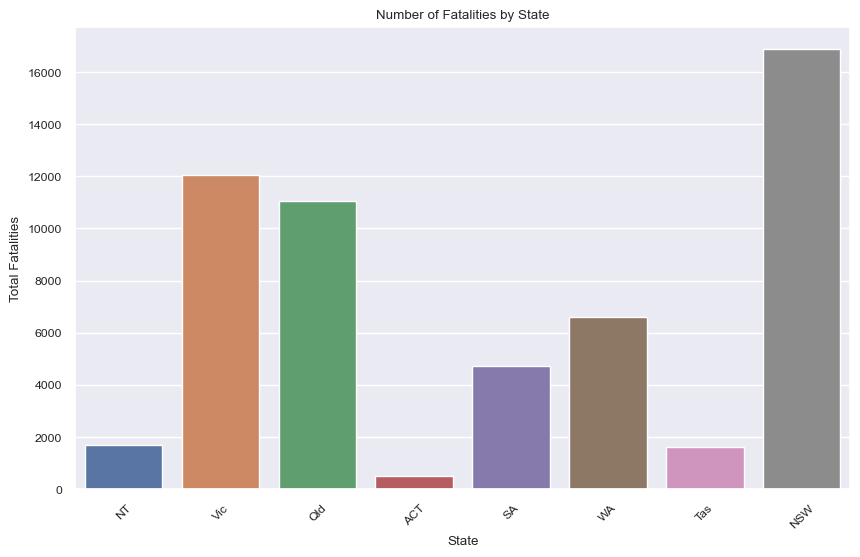

In [86]:
# Group the data by categorical variable and sum 'NUMBER_FATALITIES'
grouped_data = df_crashes_spark.groupby('STATE').agg({'NUMBER_FATALITIES': 'sum'}).toPandas()

# Create a bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='STATE', y='sum(NUMBER_FATALITIES)', data=grouped_data)
plt.title('Number of Fatalities by State')
plt.xlabel('State')
plt.ylabel('Total Fatalities')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

This could be something we can investigate further. NSW has a high number, but so do QLD and VIC.

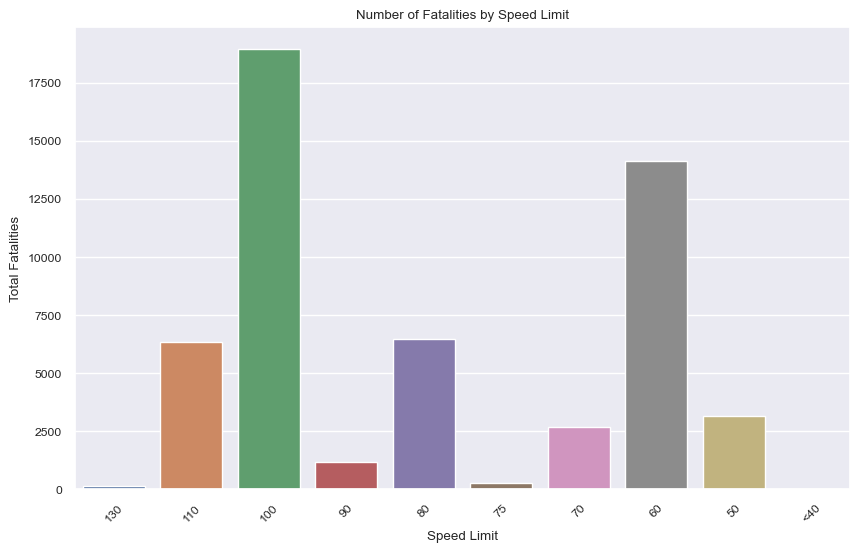

In [87]:
# Custom order for SPEED_LIMIT categories
custom_order = ['130', '110', '100', '90', '80', '75', '70', '60', '50', '<40']

# Group the data by categorical variable and sum 'NUMBER_FATALITIES'
grouped_data = df_crashes_spark.groupby('SPEED_LIMIT').agg({'NUMBER_FATALITIES': 'sum'}).toPandas()

# Create a new column 'SPEED_LIMIT_ORDERED' with custom order
grouped_data['SPEED_LIMIT_ORDERED'] = pd.Categorical(grouped_data['SPEED_LIMIT'], categories=custom_order, ordered=True)

# Sort the data frame by the custom-ordered variable
grouped_data = grouped_data.sort_values(by='SPEED_LIMIT_ORDERED')

# Create a bar chart using Seaborn with custom order
plt.figure(figsize=(10, 6))
sns.barplot(x='SPEED_LIMIT_ORDERED', y='sum(NUMBER_FATALITIES)', data=grouped_data)
plt.title('Number of Fatalities by Speed Limit')
plt.xlabel('Speed Limit')
plt.ylabel('Total Fatalities')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Speed limits of 100km/hr and 60km/hr have high numbers of fatalities. Due to being most common speed limits?

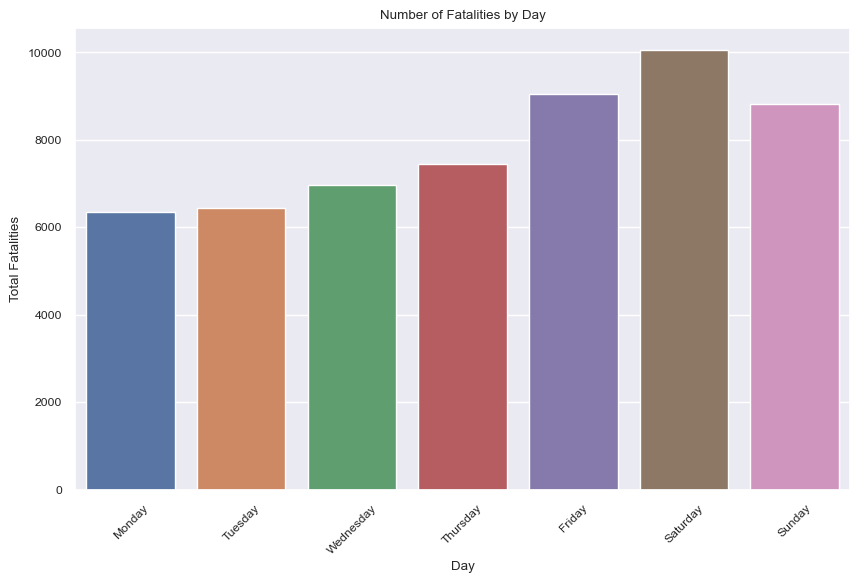

In [88]:
# Custom order for DAYOFWEEK categories
custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group the data by categorical variable and sum 'NUMBER_FATALITIES'
grouped_data = df_crashes_spark.groupby('DAYWEEK').agg({'NUMBER_FATALITIES': 'sum'}).toPandas()

# Create a new column 'SPEED_LIMIT_ORDERED' with custom order
grouped_data['DAYS'] = pd.Categorical(grouped_data['DAYWEEK'], categories=custom_order, ordered=True)

# Sort the data frame by the custom-ordered variable
grouped_data = grouped_data.sort_values(by='DAYS')

# Create a bar chart using Seaborn with custom order
plt.figure(figsize=(10, 6))
sns.barplot(x='DAYS', y='sum(NUMBER_FATALITIES)', data=grouped_data)
plt.title('Number of Fatalities by Day')
plt.xlabel('Day')
plt.ylabel('Total Fatalities')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

The weekend looks to be more dangerous on the roads. This could be due to more people being on the road at those times.

### Clean data


Missing values are represented by -9's in the dataset. We need to remove these.

In [89]:
# Remove '-9's 

# Define the condition to remove rows with '-9' or 'NaN' in any column
condition = (
    (df_crashes_spark.STATE != '-9') &
    (df_crashes_spark.MONTH != '-9') &
    (df_crashes_spark.YEAR != '-9') &
    (df_crashes_spark.DAYWEEK != '-9') &
    (df_crashes_spark.TIME != '-9') &
    (df_crashes_spark.CRASH_TYPE != '-9') &
    (df_crashes_spark.NUMBER_FATALITIES != '-9') &
    (df_crashes_spark.BUS_INVOLVEMENT != '-9') &
    (df_crashes_spark.HEAVY_TRUCK_INVOLVEMENT != '-9') &
    (df_crashes_spark.ARTICULATED_TRUCK_INVOLVEMENT != '-9') &
    (df_crashes_spark.SPEED_LIMIT != '-9') &
    (df_crashes_spark.CHRISTMAS != '-9') &
    (df_crashes_spark.EASTER != '-9') &
    (df_crashes_spark.DAYOFWEEK != '-9') &
    (df_crashes_spark.TIMEOFDAY != '-9')
)

# Apply the filter
df_crashes_spark = df_crashes_spark.filter(condition)

# Show the resulting DataFrame
df_crashes_spark.show()


+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+--------------------+--------------------+---------+------+---------+---------+--------------+
|CRASH_ID|STATE|MONTH|YEAR|  DAYWEEK|                TIME|CRASH_TYPE|NUMBER_FATALITIES|BUS_INVOLVEMENT|HEAVY_TRUCK_INVOLVEMENT|ARTICULATED_TRUCK_INVOLVEMENT|SPEED_LIMIT| NATIONAL_REMOTENESS|            SA4_NAME|        NATIONAL_LGA|  NATIONAL_ROAD_TYPE|CHRISTMAS|EASTER|DAYOFWEEK|TIMEOFDAY|DEATH_CATEGORY|
+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+--------------------+--------------------+---------+------+---------+---------+--------------+
|20235045|   WA|    8|2023|   Sunday|Time: 9 hours, 5 ...|    Single|             

There are some columns with the values literally being 'NaN'. We need to remove these too. <br><br>
Only for the key variables we care about. 

In [90]:
# Define the condition to remove rows with 'NaN' in any column (case-insensitive and with whitespace trimmed)
condition = (
    (lower(trim(col("STATE"))) != 'nan') &
    (lower(trim(col("MONTH"))) != 'nan') &
    (lower(trim(col("YEAR"))) != 'nan') &
    (lower(trim(col("DAYWEEK"))) != 'nan') &
    (lower(trim(col("TIME"))) != 'nan') &
    (lower(trim(col("CRASH_TYPE"))) != 'nan') &
    (lower(trim(col("NUMBER_FATALITIES"))) != 'nan') &
    (lower(trim(col("SPEED_LIMIT"))) != 'nan') &
    (lower(trim(col("CHRISTMAS"))) != 'nan') &
    (lower(trim(col("EASTER"))) != 'nan') &
    (lower(trim(col("DAYOFWEEK"))) != 'nan') &
    (lower(trim(col("TIMEOFDAY"))) != 'nan')
)

# Apply the filter
df_crashes_spark = df_crashes_spark.filter(condition)

# Also remove NA's
df_crashes_spark = df_crashes_spark.na.drop()

# Show the resulting DataFrame
df_crashes_spark.show()


+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+--------------------+--------------------+---------+------+---------+---------+--------------+
|CRASH_ID|STATE|MONTH|YEAR|  DAYWEEK|                TIME|CRASH_TYPE|NUMBER_FATALITIES|BUS_INVOLVEMENT|HEAVY_TRUCK_INVOLVEMENT|ARTICULATED_TRUCK_INVOLVEMENT|SPEED_LIMIT| NATIONAL_REMOTENESS|            SA4_NAME|        NATIONAL_LGA|  NATIONAL_ROAD_TYPE|CHRISTMAS|EASTER|DAYOFWEEK|TIMEOFDAY|DEATH_CATEGORY|
+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+--------------------+--------------------+---------+------+---------+---------+--------------+
|20235045|   WA|    8|2023|   Sunday|Time: 9 hours, 5 ...|    Single|             

### Summary stats for numeric variables

In [91]:
# Summary stats for crash data
numeric_features2 = [t[0] for t in df_crashes_spark.dtypes if t[1] == 'int']
df_crashes_spark.select(numeric_features2).describe().toPandas().transpose()

0                   1                    2     3     4
summary            count                mean               stddev   min   max
YEAR               30974  2008.8521340479112    8.757447488401667  1989  2023
NUMBER_FATALITIES  30974  1.0983728288241752  0.38248795091512594     1    11

### Join Datasets


Joining crashes dataset with locations database to see if there is any association. 

In [92]:
# Using geopandas

geography_type = "SSC"

# Assign location keys 
geography_type_fields = { 
    "SA1": { "geo_key": "SA1_7DIGIT", "data_key": "SA1_7DIGITCODE_2016" },
    "SA2": { "geo_key": "SA2_7DIGIT", "data_key": "SA2_7DIGITCODE_2016" },
    "SA3": { "geo_key": "SA3_7DIGIT", "data_key": "SA3_7DIGITCODE_2016" },
    "SA4": { "geo_key": "SA4_CODE", "data_key": "SA4_CODE_2016" },
    "SSC": { "geo_key": "SSC_CODE", "data_key": "SSC_CODE_2016" },
}
geo_key = geography_type_fields[geography_type]["geo_key"]
data_key = geography_type_fields[geography_type]["data_key"]

<Axes: >

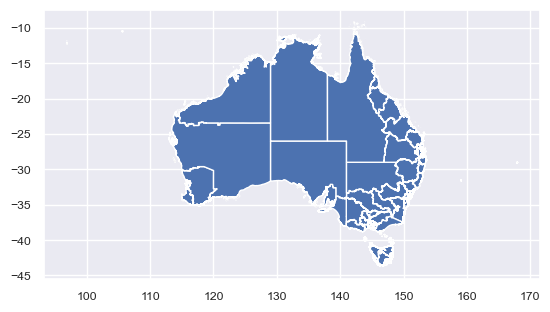

In [93]:
# Reading data in to plot the map using geopandas. 
shapes = "./shapes/SA4_2016_AUST.shp"

shapes_gpd = gpd.read_file(shapes)

shapes_gpd.plot()

Merge the dataframes so that we can plot the crash data on the map. 

In [94]:
# Merge the pandas dataframes
result_gdf = pd.merge(shapes_gpd, df_crashes_spark.toPandas())


In [95]:
result_gdf

SA4_CODE SA4_CODE16                SA4_NAME STATE_CODE  STATE_NAME   
0         212        212  Melbourne - South East          2    Victoria  \
1         212        212  Melbourne - South East          2    Victoria   
2         212        212  Melbourne - South East          2    Victoria   
3         212        212  Melbourne - South East          2    Victoria   
4         212        212  Melbourne - South East          2    Victoria   
...       ...        ...                     ...        ...         ...   
8791      310        310                 Ipswich          3  Queensland   
8792      310        310                 Ipswich          3  Queensland   
8793      310        310                 Ipswich          3  Queensland   
8794      310        310                 Ipswich          3  Queensland   
8795      310        310                 Ipswich          3  Queensland   

      AREA_SQKM                                           geometry  CRASH_ID   
0     1922.2805  POLYGON ((145.76502 -37.89858, 145.76514 -37.8...  20232037  \
1     1922.2805  POLYGON ((145.76502 -37.89858, 145.76514 -37.8...  20232013   
2     1922.2805  POLYGON ((145.76502 -37.89858, 145.76514 -37.8...  20232127   
3     1922.2805  POLYGON ((145.76502 -37.89858, 145.76514 -37.8...  20232106   
4     1922.2805  POLYGON ((145.76502 -37.89858, 145.76514 -37.8...  20232076   
...         ...                                                ...       ...   
8791  6681.1469  POLYGON ((152.96541 -27.54463, 152.96697 -27.5...  20173090   
8792  6681.1469  POLYGON ((152.96541 -27.54463, 152.96697 -27.5...  20173074   
8793  6681.1469  POLYGON ((152.96541 -27.54463, 152.96697 -27.5...  20173205   
8794  6681.1469  POLYGON ((152.96541 -27.54463, 152.96697 -27.5...  20173136   
8795  6681.1469  POLYGON ((152.96541 -27.54463, 152.96697 -27.5...  20173224   

     STATE MONTH  ...  ARTICULATED_TRUCK_INVOLVEMENT SPEED_LIMIT   
0      Vic     7  ...                             No          50  \
1      Vic     7  ...                             No          80   
2      Vic     6  ...                             No          60   
3      Vic     6  ...                             No          60   
4      Vic     5  ...                            Yes          80   
...    ...   ...  ...                            ...         ...   
8791   Qld     6  ...                             No          50   
8792   Qld     5  ...                            Yes         100   
8793   Qld     4  ...                             No          60   
8794   Qld     3  ...                             No         100   
8795   Qld     2  ...                             No         100   

            NATIONAL_REMOTENESS       NATIONAL_LGA         NATIONAL_ROAD_TYPE   
0     Major Cities of Australia              Casey          Sub-arterial Road  \
1     Major Cities of Australia  Greater Dandenong              Arterial Road   
2     Major Cities of Australia             Monash          Sub-arterial Road   
3     Major Cities of Australia              Casey                 Local Road   
4     Major Cities of Australia              Casey          Sub-arterial Road   
...                         ...                ...                        ...   
8791  Major Cities of Australia           Brisbane                 Local Road   
8792   Inner Regional Australia           Somerset  National or State Highway   
8793   Inner Regional Australia           Somerset          Sub-arterial Road   
8794   Inner Regional Australia         Scenic Rim  National or State Highway   
8795   Inner Regional Australia           Somerset                 Local Road   

     CHRISTMAS EASTER DAYOFWEEK TIMEOFDAY DEATH_CATEGORY  
0           No     No   Weekday     Night         Single  
1           No     No   Weekday       Day         Single  
2           No     No   Weekend     Night         Single  
3           No     No   Weekday       Day         Single  
4           No     No   Weekday       Day         Single  

<Axes: >

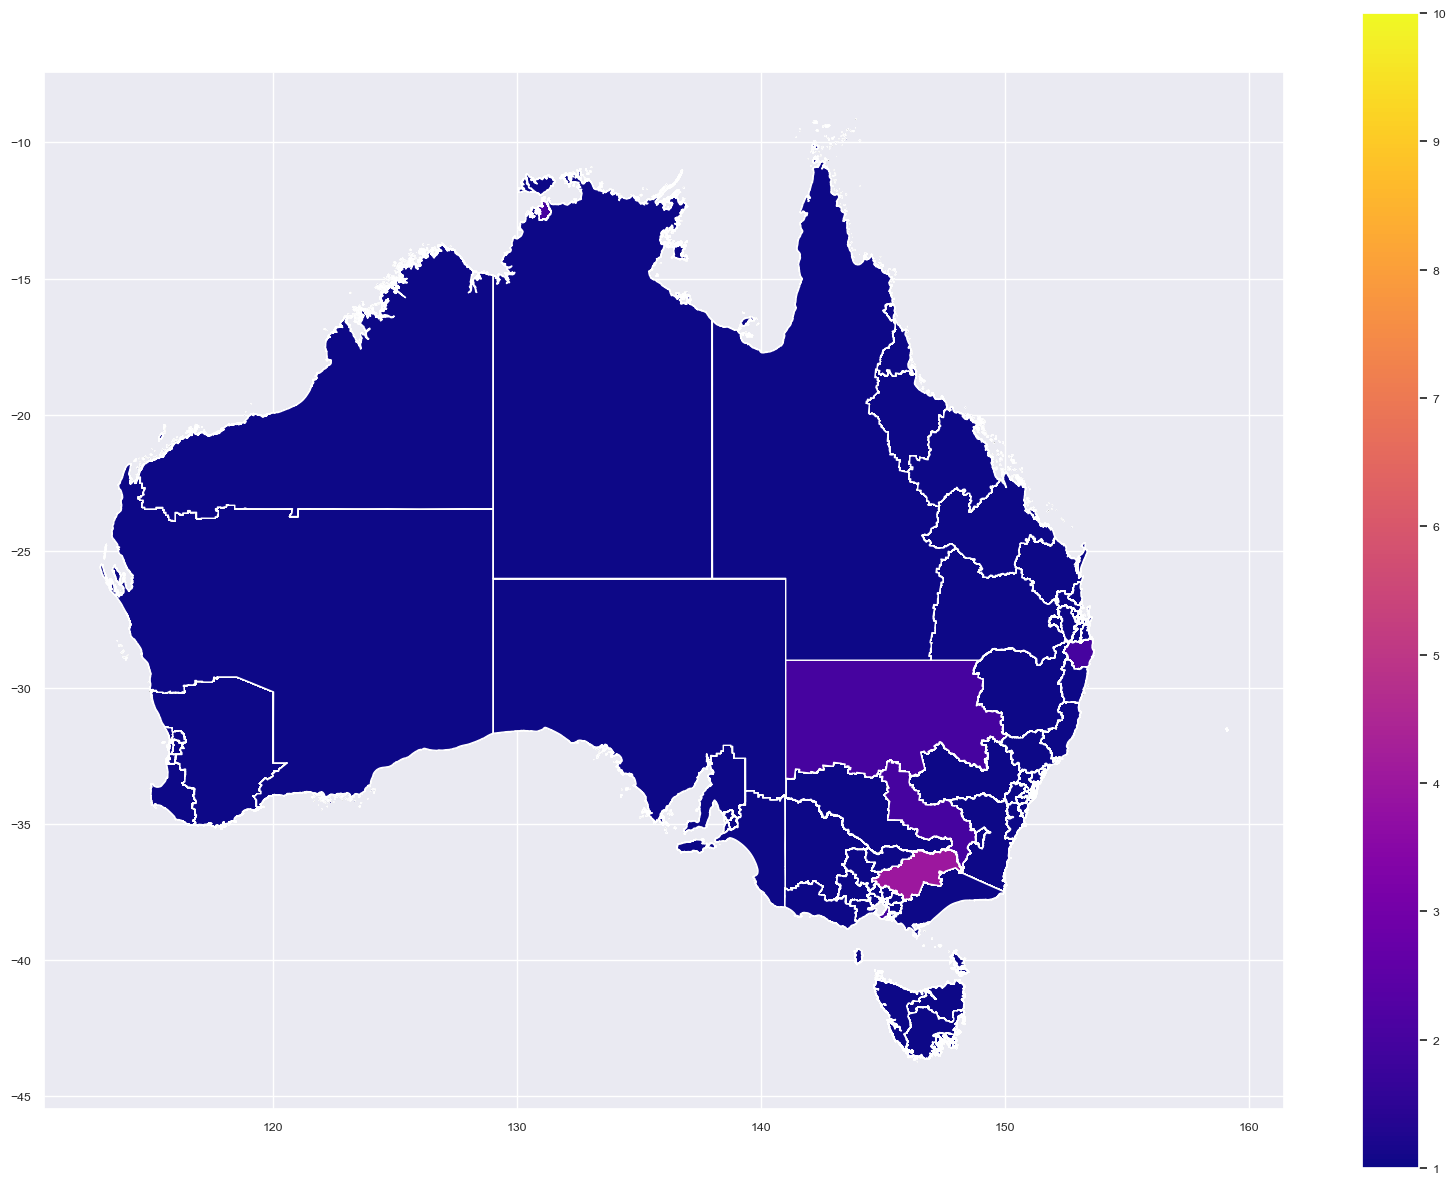

In [96]:
# Plot the choropleth map based on the aggregated NUMBER_FATALITIES values
result_gdf.plot(column='NUMBER_FATALITIES', legend=True, figsize=(20, 15), cmap='plasma')

Not much of a relationship can be seen. Some hotspots in regional areas. 

In [97]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df_crashes_spark.toPandas()


# Group by 'SA4_NAME' and calculate the total 'NUMBER_FATALITIES'
grouped_df = pandas_df.groupby('SA4_NAME', as_index=False)['NUMBER_FATALITIES'].sum()

# Sort the Pandas DataFrame by 'NUMBER_FATALITIES' in descending order
sorted_df = grouped_df.sort_values(by='NUMBER_FATALITIES', ascending=False)

# Show the top 10 SA4_NAME values with the highest total Number Fatalities
top_10_sa4_by_sum_fatalities = sorted_df.head(10)
print(top_10_sa4_by_sum_fatalities)

                          SA4_NAME  NUMBER_FATALITIES
48                             NaN              23563
83                         Unknown                930
88  Western Australia - Wheat Belt                297
63    South Australia - South East                252
89                        Wide Bay                245
15                  Capital Region                228
52    Northern Territory - Outback                211
41          Melbourne - South East                200
18                    Central West                198
49      New England and North West                197


In [98]:
# Checking outliers for fatalities
 
df_crashes_sorted = df_crashes_spark.orderBy('NUMBER_FATALITIES', ascending=False)

top_10_fatalities = df_crashes_sorted.limit(10)

top_10_fatalities.show()

+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+------------+--------------------+---------+------+---------+---------+--------------+
|CRASH_ID|STATE|MONTH|YEAR|  DAYWEEK|                TIME|CRASH_TYPE|NUMBER_FATALITIES|BUS_INVOLVEMENT|HEAVY_TRUCK_INVOLVEMENT|ARTICULATED_TRUCK_INVOLVEMENT|SPEED_LIMIT| NATIONAL_REMOTENESS|            SA4_NAME|NATIONAL_LGA|  NATIONAL_ROAD_TYPE|CHRISTMAS|EASTER|DAYOFWEEK|TIMEOFDAY|DEATH_CATEGORY|
+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+------------+--------------------+---------+------+---------+---------+--------------+
|20072222|  Vic|    6|2007|  Tuesday|Time: 13 hours, 3...|  Multiple|               11|             No|   

In [99]:
# Group by 'SA4_NAME' and calculate the average 'NUMBER_FATALITIES'
grouped_df = df_crashes_spark.groupBy('SA4_NAME').agg(avg('NUMBER_FATALITIES').alias('AvgFatalities'))

# Sort the DataFrame by 'AvgFatalities' in descending order and limit to the top 10 records
top_10_sa4_by_avg_fatalities = grouped_df.orderBy(col('AvgFatalities').desc()).limit(10)

# Show the top 10 SA4_NAME values with the highest average Number Fatalities
top_10_sa4_by_avg_fatalities.show()

+--------------------+------------------+
|            SA4_NAME|     AvgFatalities|
+--------------------+------------------+
|Northern Territor...|1.1787709497206704|
|Sydney - Outer So...|1.1746031746031746|
|Darling Downs - M...|1.1694915254237288|
|          Townsville|1.1473684210526316|
|Western Australia...| 1.146341463414634|
|Western Australia...|1.1411764705882352|
|              Cairns|1.1363636363636365|
|            Ballarat|1.1333333333333333|
|South Australia -...|1.1333333333333333|
|Barossa - Yorke -...| 1.129251700680272|
+--------------------+------------------+



Not enough location data filled in to find a relationship/use the data in the model.

In [100]:
df_crashes_spark.printSchema()

root
 |-- CRASH_ID: string (nullable = false)
 |-- STATE: string (nullable = true)
 |-- MONTH: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- DAYWEEK: string (nullable = true)
 |-- TIME: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- NUMBER_FATALITIES: integer (nullable = true)
 |-- BUS_INVOLVEMENT: string (nullable = true)
 |-- HEAVY_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- ARTICULATED_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- SPEED_LIMIT: string (nullable = true)
 |-- NATIONAL_REMOTENESS: string (nullable = true)
 |-- SA4_NAME: string (nullable = true)
 |-- NATIONAL_LGA: string (nullable = true)
 |-- NATIONAL_ROAD_TYPE: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- DAYOFWEEK: string (nullable = true)
 |-- TIMEOFDAY: string (nullable = true)
 |-- DEATH_CATEGORY: string (nullable = false)



Removing location data from the model. 

In [101]:
# Choose columns
df_crashes_spark = df_crashes_spark.na.drop()

df_crashes_spark = df_crashes_spark.select(
    'DAYWEEK',
    'CRASH_TYPE',
    'NUMBER_FATALITIES',
    'BUS_INVOLVEMENT',
    'HEAVY_TRUCK_INVOLVEMENT',
    'ARTICULATED_TRUCK_INVOLVEMENT',
    'SPEED_LIMIT',
    'DAYOFWEEK',
    'TIMEOFDAY',
    'DEATH_CATEGORY')

cols = df_crashes_spark.columns
df_crashes_spark.printSchema()

root
 |-- DAYWEEK: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- NUMBER_FATALITIES: integer (nullable = true)
 |-- BUS_INVOLVEMENT: string (nullable = true)
 |-- HEAVY_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- ARTICULATED_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- SPEED_LIMIT: string (nullable = true)
 |-- DAYOFWEEK: string (nullable = true)
 |-- TIMEOFDAY: string (nullable = true)
 |-- DEATH_CATEGORY: string (nullable = false)



### Preparing data for machine learning 

<br> <br> From databricks website


In [102]:
# Category Indexing
categoricalColumns = [
    'DAYWEEK',
    'CRASH_TYPE',
    'NUMBER_FATALITIES',
    'BUS_INVOLVEMENT',
    'HEAVY_TRUCK_INVOLVEMENT',
    'ARTICULATED_TRUCK_INVOLVEMENT',
    'SPEED_LIMIT',
    'DAYOFWEEK',
    'TIMEOFDAY',
    'DEATH_CATEGORY']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'DEATH_CATEGORY', outputCol = 'label')
stages += [label_stringIdx]

assemblerInputs = [c + "classVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

### Pipeline


In [103]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_crashes_spark)
df_transformed = pipelineModel.transform(df_crashes_spark)
selectedCols = ['label', 'features'] + cols
df_transformed = df_transformed.select(selectedCols)
df_transformed.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- DAYWEEK: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- NUMBER_FATALITIES: integer (nullable = true)
 |-- BUS_INVOLVEMENT: string (nullable = true)
 |-- HEAVY_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- ARTICULATED_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- SPEED_LIMIT: string (nullable = true)
 |-- DAYOFWEEK: string (nullable = true)
 |-- TIMEOFDAY: string (nullable = true)
 |-- DEATH_CATEGORY: string (nullable = false)



In [104]:
pd.DataFrame(df_transformed.take(5), columns=df_transformed.columns).transpose()

0   
label                                                                        0.0  \
features                       (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...   
DAYWEEK                                                                   Sunday   
CRASH_TYPE                                                                Single   
NUMBER_FATALITIES                                                              1   
BUS_INVOLVEMENT                                                               No   
HEAVY_TRUCK_INVOLVEMENT                                                       No   
ARTICULATED_TRUCK_INVOLVEMENT                                                 No   
SPEED_LIMIT                                                                   90   
DAYOFWEEK                                                                Weekend   
TIMEOFDAY                                                                    Day   
DEATH_CATEGORY                                                            Single   

                                                                               1   
label                                                                        0.0  \
features                       (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
DAYWEEK                                                                   Friday   
CRASH_TYPE                                                              Multiple   
NUMBER_FATALITIES                                                              1   
BUS_INVOLVEMENT                                                               No   
HEAVY_TRUCK_INVOLVEMENT                                                       No   
ARTICULATED_TRUCK_INVOLVEMENT                                                 No   
SPEED_LIMIT                                                                   60   
DAYOFWEEK                                                                Weekend   
TIMEOFDAY                                                                  Night   
DEATH_CATEGORY                                                            Single   

                                                                               2   
label                                                                        0.0  \
features                       (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
DAYWEEK                                                                   Friday   
CRASH_TYPE                                                              Multiple   
NUMBER_FATALITIES                                                              1   
BUS_INVOLVEMENT                                                               No   
HEAVY_TRUCK_INVOLVEMENT                                                      Yes   
ARTICULATED_TRUCK_INVOLVEMENT                                                 No   
SPEED_LIMIT                                                                   50   
DAYOFWEEK                                                                Weekend   
TIMEOFDAY                                                                  Night   
DEATH_CATEGORY                                                            Single   

                                                                               3   
label                                                                        0.0  \
features                       (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...   
DAYWEEK                                                                   Sunday   
CRASH_TYPE                                                                Single   
NUMBER_FATALITIES                                                              1   
BUS_INVOLVEMENT                                                               No   
HEAVY_TRUCK_INVOLVEMENT                                                       No   
ARTICULATED_TRUCK_INVOLVEMENT                                                 No   
SPEED_LIMIT                                 

In [105]:
# Split data into train and test
train, test = df_transformed.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 21805
Test Dataset Count: 9169


### Logistic Regression Model

In [106]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [107]:
test.describe().show()

+-------+------------------+---------+----------+------------------+---------------+-----------------------+-----------------------------+------------------+---------+---------+--------------+
|summary|             label|  DAYWEEK|CRASH_TYPE| NUMBER_FATALITIES|BUS_INVOLVEMENT|HEAVY_TRUCK_INVOLVEMENT|ARTICULATED_TRUCK_INVOLVEMENT|       SPEED_LIMIT|DAYOFWEEK|TIMEOFDAY|DEATH_CATEGORY|
+-------+------------------+---------+----------+------------------+---------------+-----------------------+-----------------------------+------------------+---------+---------+--------------+
|  count|              9169|     9169|      9169|              9169|           9169|                   9169|                         9169|              9169|     9169|     9169|          9169|
|   mean|0.0807067291962046|     null|      null|1.1006652852001308|           null|                   null|                         null| 81.98876649580107|     null|     null|          null|
| stddev|0.2723990559456145|     nu

In [108]:
train.describe().show()

+-------+-------------------+---------+----------+-------------------+---------------+-----------------------+-----------------------------+------------------+---------+---------+--------------+
|summary|              label|  DAYWEEK|CRASH_TYPE|  NUMBER_FATALITIES|BUS_INVOLVEMENT|HEAVY_TRUCK_INVOLVEMENT|ARTICULATED_TRUCK_INVOLVEMENT|       SPEED_LIMIT|DAYOFWEEK|TIMEOFDAY|DEATH_CATEGORY|
+-------+-------------------+---------+----------+-------------------+---------------+-----------------------+-----------------------------+------------------+---------+---------+--------------+
|  count|              21805|    21805|     21805|              21805|          21805|                  21805|                        21805|             21805|    21805|    21805|         21805|
|   mean|0.07800963081861959|     null|      null|  1.097408851180922|           null|                   null|                         null| 82.02312138728324|     null|     null|          null|
| stddev| 0.2681928913764

In [109]:
coeff = lrModel.coefficients

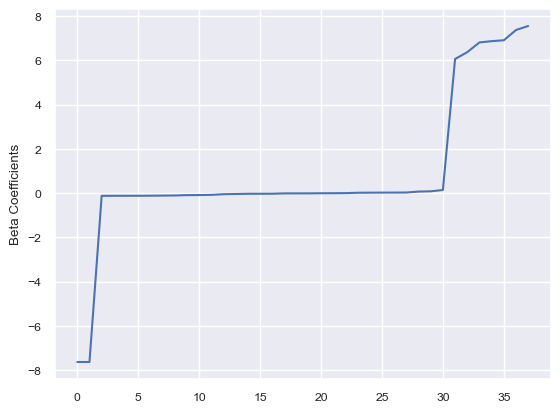

In [110]:
beta = np.sort(coeff)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [111]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Training set areaUnderROC: 1.0


In [112]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [113]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [114]:
predictions = lrModel.transform(test)
predictions.select('SPEED_LIMIT', 'TIMEOFDAY', 'rawPrediction', 'prediction', 'probability').show(10)

+-----------+---------+--------------------+----------+--------------------+
|SPEED_LIMIT|TIMEOFDAY|       rawPrediction|prediction|         probability|
+-----------+---------+--------------------+----------+--------------------+
|        100|      Day|[8.71248519205068...|       0.0|[0.99983550817703...|
|        100|      Day|[8.71248519205068...|       0.0|[0.99983550817703...|
|        100|      Day|[8.71248519205068...|       0.0|[0.99983550817703...|
|        100|      Day|[8.71248519205068...|       0.0|[0.99983550817703...|
|        100|      Day|[8.71248519205068...|       0.0|[0.99983550817703...|
|        100|      Day|[8.71248519205068...|       0.0|[0.99983550817703...|
|        100|      Day|[8.71248519205068...|       0.0|[0.99983550817703...|
|        100|      Day|[8.71248519205068...|       0.0|[0.99983550817703...|
|        100|      Day|[8.71248519205068...|       0.0|[0.99983550817703...|
|        100|      Day|[8.71248519205068...|       0.0|[0.99983550817703...|

In [115]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9999999999999999


In [116]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 1.0


### Decision Tree Classifier


In [117]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('SPEED_LIMIT', 'TIMEOFDAY','rawPrediction', 'prediction', 'probability').show(10)

+-----------+---------+-------------+----------+-----------+
|SPEED_LIMIT|TIMEOFDAY|rawPrediction|prediction|probability|
+-----------+---------+-------------+----------+-----------+
|        100|      Day|[20104.0,0.0]|       0.0|  [1.0,0.0]|
|        100|      Day|[20104.0,0.0]|       0.0|  [1.0,0.0]|
|        100|      Day|[20104.0,0.0]|       0.0|  [1.0,0.0]|
|        100|      Day|[20104.0,0.0]|       0.0|  [1.0,0.0]|
|        100|      Day|[20104.0,0.0]|       0.0|  [1.0,0.0]|
|        100|      Day|[20104.0,0.0]|       0.0|  [1.0,0.0]|
|        100|      Day|[20104.0,0.0]|       0.0|  [1.0,0.0]|
|        100|      Day|[20104.0,0.0]|       0.0|  [1.0,0.0]|
|        100|      Day|[20104.0,0.0]|       0.0|  [1.0,0.0]|
|        100|      Day|[20104.0,0.0]|       0.0|  [1.0,0.0]|
+-----------+---------+-------------+----------+-----------+
only showing top 10 rows



In [118]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 1.0


In [119]:
evaluator.getMetricName()

'areaUnderROC'

### Random Forest Classifier


In [120]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('SPEED_LIMIT', 'TIMEOFDAY', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----------+---------+-----+--------------------+----------+--------------------+
|SPEED_LIMIT|TIMEOFDAY|label|       rawPrediction|prediction|         probability|
+-----------+---------+-----+--------------------+----------+--------------------+
|        100|      Day|  0.0|[19.8405429216017...|       0.0|[0.99202714608008...|
|        100|      Day|  0.0|[19.8405429216017...|       0.0|[0.99202714608008...|
|        100|      Day|  0.0|[19.8405429216017...|       0.0|[0.99202714608008...|
|        100|      Day|  0.0|[19.8405429216017...|       0.0|[0.99202714608008...|
|        100|      Day|  0.0|[19.8405429216017...|       0.0|[0.99202714608008...|
|        100|      Day|  0.0|[19.8405429216017...|       0.0|[0.99202714608008...|
|        100|      Day|  0.0|[19.8405429216017...|       0.0|[0.99202714608008...|
|        100|      Day|  0.0|[19.8405429216017...|       0.0|[0.99202714608008...|
|        100|      Day|  0.0|[19.8405429216017...|       0.0|[0.99202714608008...|
|   

In [121]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 1.0


In [122]:
evaluator.getMetricName()

'areaUnderROC'

In [123]:
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

In [124]:
spark.stop()


Fatalities main data set. Join locations dataset and plot. See if there are certain hotspots. 

Remove year, month values because we are trying to determine risk. 